<a href="https://colab.research.google.com/github/muhammadaatifma/FirstPushProject/blob/master/TransE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install ampligraph
!pip install seaborn adjustText
!pip install tensorflow==1.13.2

  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7100 sha256=682977951c0b461caba7e44fff4a75a85eb39facd95961479929bcef0bc8d405
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [0]:
import numpy as np
import pandas as pd
import ampligraph

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [0]:
from google.colab import files
uploaded = files.upload()

Saving classdataresult (1).xlsx to classdataresult (1) (3).xlsx


In [0]:
df = pd.read_excel('classdataresult (1).xlsx')
triples_df = df[['number1', 'verbs', 'number2']]
triples_df.columns = ['subject', 'predicate', 'object']
triples_df.head()

,subject,predicate,object
0,A00-1031,have,A92-1018
1,A00-1043,identify,A00-2024
2,A92-1013,build,J90-1003
3,A92-1013,observe,J90-1003
4,A94-1008,use,A92-1018


In [0]:
from ampligraph.evaluation import train_test_split_no_unseen 

X_train, X_valid = train_test_split_no_unseen(np.array(triples_df), test_size=0.30)

In [0]:
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (490, 3)
Test set size:  (210, 3)


In [0]:
from ampligraph.latent_features import TransE

model = TransE(batches_count=50,
               k=100, 
               eta=20, 
               epochs=300, 
               seed=0, 
               optimizer='adam', 
               optimizer_params={'lr': 0.0005}, 
               loss='nll', loss_params={}, 
               regularizer=None, regularizer_params={}, 
               initializer='xavier', 
               verbose=True)

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train)

Average Loss:   0.894432: 100%|██████████| 300/300 [00:18<00:00, 15.89epoch/s]


In [0]:
filter_triples = np.concatenate((X_train, X_valid))

In [0]:
from ampligraph.evaluation import evaluate_performance

ranks = evaluate_performance(X_valid,
                             model=model, 
                             filter_triples=filter_triples,
                             use_default_protocol=True,
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 210/210 [00:00<00:00, 586.99it/s]


In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

In [0]:
matplotlib inline

In [0]:
class_map = {**dict(triples_df.subject), **dict(triples_df.object)}

In [0]:
classes = pd.concat((triples_df.subject, triples_df.object)).unique()
embeddings = dict(zip(classes, model.get_embeddings(classes)))

In [0]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in embeddings.values()]))

In [0]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=8, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(classes, model, clustering_algorithm, mode='entity')

In [0]:
plot_df = pd.DataFrame({"classes": classes, 
                        "train_embedding": embeddings_2d[:, 0], 
                        "test_embedding": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

In [0]:
topcitingpapers = triples_df.subject.value_counts().head()
def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())
    ax = sns.scatterplot(data=plot_df, x="train_embedding", y="test_embedding", hue=hue)
    texts = []
    for i, point in plot_df.iterrows():
        if point["classes"] in topcitingpapers or np.random.random() < 0.1:
            texts.append(plt.text(point['train_embedding']+0.02, point['train_embedding']+0.01, str(point["classes"])))
    adjust_text(texts)

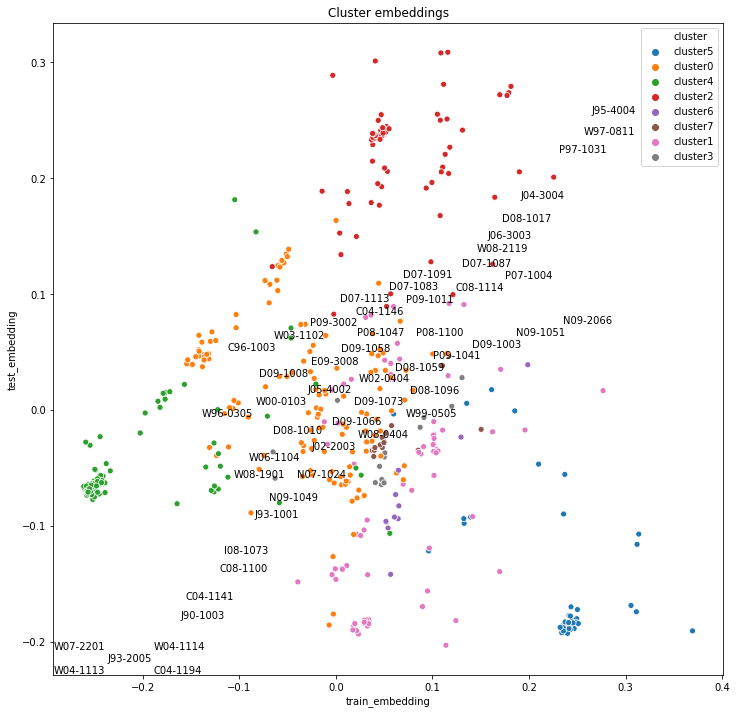

In [0]:
plot_clusters("cluster")

In [0]:
df["results"] = df['Sub Class']

In [0]:
df.results.value_counts(normalize=True)

Discuss        0.582857
Compare        0.278571
Incorporate    0.065714
Extend         0.031429
Criticize      0.021429
BasedOn        0.012857
Negate         0.004286
Contrast       0.002857
Name: results, dtype: float64

In [0]:
def get_features_target(mask):
    
    def get_embeddings(clas):
        return embeddings.get(clas, np.full(200, np.nan))
    
    X = np.hstack((np.vstack(triples_df[mask].subject.apply(get_embeddings).values),
                   np.vstack(triples_df[mask].object.apply(get_embeddings).values)))
    y = df[mask].results.values
    return X, y

In [0]:
clf_X_train, y_train = get_features_target((np.random.rand(len(triples_df)) < 0.8))
clf_X_test, y_test = get_features_target((~(np.random.rand(len(triples_df)) < 0.8)))

In [0]:
clf_X_train.shape, clf_X_test.shape

((549, 200), (165, 200))

In [0]:
np.isnan(clf_X_test).sum()/clf_X_test.shape[1]

0.0

In [0]:
!pip install xgboost
from xgboost import XGBClassifier

In [0]:
clf_model = XGBClassifier(n_estimators=500, max_depth=5, objective="multi:softmax")

In [0]:
clf_model.fit(clf_X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
df[~(np.random.rand(len(triples_df)) < 0.8)]['Sub Class'].value_counts(normalize=True)

Discuss        0.600000
Compare        0.278571
Extend         0.050000
Criticize      0.028571
Incorporate    0.028571
Contrast       0.007143
BasedOn        0.007143
Name: Sub Class, dtype: float64

In [0]:
import sklearn.metrics as metrics
metrics.accuracy_score(y_test, clf_model.predict(clf_X_test))

0.806060606060606

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf_model.predict(clf_X_test)))

In [0]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, clf_model.predict(clf_X_test)))